In [ ]:
# 1. Instalação e importação
!pip install scikit-learn tensorflow opencv-python matplotlib pillow pillow-heif --quiet
import os, cv2, numpy as np, matplotlib.pyplot as plt, itertools
from google.colab import drive, files
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, Input
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from scipy.spatial.distance import cdist


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.5/5.5 MB 40.2 MB/s eta 0:00:00


In [ ]:
# 2. Montar Google Drive e carregar imagens

drive.mount('/content/drive')
base_dir = '/content/drive/MyDrive/fotos_rostos'
IMG_SIZE = (96, 128)  # largura, altura
classes = sorted([d for d in os.listdir(base_dir) if os.path.isdir(os.path.join(base_dir, d))])
print('Classes detectadas:', classes)

def preprocess_image(img_path):
    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    img = cv2.resize(img, IMG_SIZE)
    img = cv2.GaussianBlur(img, (3,3), 0)
    img = img / 255.0
    return img

X, y = [], []
for label in classes:
    folder = os.path.join(base_dir, label)
    for fname in os.listdir(folder):
        if fname.lower().endswith(('.jpg','.jpeg','.png')):
            img = preprocess_image(os.path.join(folder, fname))
            X.append(img)
            y.append(label)
X = np.array(X)
y = np.array(y)
print('Total imagens:', X.shape[0])


Mounted at /content/drive
Classes detectadas: ['Kayky', 'Lucas', 'Marcelo', 'Matheus', 'Pedro', 'Rhyan', 'Sandro']
Total imagens: 350


In [ ]:
# 3. Split estratificado entre treino e teste antes do augmentation

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, stratify=y, random_state=42
)
print('Treino:', X_train.shape, 'Teste:', X_test.shape)


Treino: (245, 128, 96, 3) Teste: (105, 128, 96, 3)


In [ ]:
# 4. Data augmentation 5x no treino somente

datagen = ImageDataGenerator(
    rotation_range=10, width_shift_range=0.1, height_shift_range=0.1,
    brightness_range=[0.8,1.2], shear_range=5, zoom_range=0.1,
    horizontal_flip=True, fill_mode='nearest'
)
Xtr_aug, ytr_aug = [], []
for i in range(len(X_train)):
    img_exp = np.expand_dims(X_train[i], 0)
    lbl = y_train[i]
    Xtr_aug.append(X_train[i]); ytr_aug.append(lbl)  # original mantida
    count = 0
    for batch in datagen.flow(img_exp, batch_size=1):
        Xtr_aug.append(batch[0])
        ytr_aug.append(lbl)
        count += 1
        if count == 5:
            break
Xtr_aug = np.array(Xtr_aug)
ytr_aug = np.array(ytr_aug)
print('Treino após augmentation:', Xtr_aug.shape)


Treino após augmentation: (1470, 128, 96, 3)


In [ ]:
# 5. Construir e treinar a CNN

def build_model(num_classes):
    inputs = Input(shape=(IMG_SIZE[1], IMG_SIZE[0], 3))
    x = Conv2D(32, (3,3), activation='relu')(inputs)
    x = MaxPooling2D(2,2)(x)
    x = Conv2D(64, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)
    x = Conv2D(128, (3,3), activation='relu')(x)
    x = MaxPooling2D(2,2)(x)
    x = Flatten()(x)
    # Um vetor de 128 características numéricas (um embedding de 128 dimensões).
    # Esses valores não são pontos geométricos literais na face, mas sim features aprendidas automaticamente pelo rede neural durante o treinamento.
    embeddings = Dense(128, activation='relu', name='embedding')(x)
    x = Dropout(0.4)(embeddings)
    outputs = Dense(num_classes, activation='softmax')(x)
    return Model(inputs, outputs)

model = build_model(len(classes))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])
model.fit(
    Xtr_aug,
    to_categorical([classes.index(lbl) for lbl in ytr_aug], num_classes=len(classes)),
    epochs=15, batch_size=32, validation_split=0.15
)
embedding_model = Model(model.input, model.get_layer('embedding').output)


Epoch 1/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 15s 137ms/step - accuracy: 0.1460 - loss: 1.9502 - val_accuracy: 0.1674 - val_loss: 1.8886
Epoch 2/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2118 - loss: 1.8373 - val_accuracy: 0.2760 - val_loss: 1.7893
Epoch 3/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.2862 - loss: 1.6466 - val_accuracy: 0.3077 - val_loss: 1.7224
Epoch 4/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3413 - loss: 1.5350 - val_accuracy: 0.3122 - val_loss: 1.7628
Epoch 5/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3764 - loss: 1.4533 - val_accuracy: 0.3665 - val_loss: 1.7674
Epoch 6/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3927 - loss: 1.4323 - val_accuracy: 0.2760 - val_loss: 1.7716
Epoch 7/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.3946 - loss: 1.4081 - val_accuracy: 0.2715 - val_loss: 1.9102
Epoch 8/15
40/40 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - accuracy: 0.4309 - loss: 1.3514 - val_accuracy: 0.2760 -

In [ ]:
# 6. Extrair embeddings de treino/teste, aplicar PCA, treinar KNN

feats_tr = embedding_model.predict(Xtr_aug, verbose=1)
feats_te = embedding_model.predict(X_test, verbose=1)
pca = PCA(n_components=32)
feats_tr_pca = pca.fit_transform(feats_tr)
feats_te_pca = pca.transform(feats_te)
knn = KNeighborsClassifier(n_neighbors=3, metric='euclidean')
knn.fit(feats_tr_pca, ytr_aug)
y_test_pred = knn.predict(feats_te_pca)


46/46 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step
4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 150ms/step


In [ ]:
feats_te_pca = pca.transform(feats_te)
print(len(feats_te_pca))

105


In [ ]:
# 7. Upload das imagens do "desconhecido" (César) para avaliação open set
uploaded = files.upload()  # opcional
X_new, y_new, min_dists = [], [], []
for fname in uploaded.keys():
    img = preprocess_image(fname)
    X_new.append(img)
    y_new.append("César")
X_new = np.array(X_new) if X_new else np.empty((0, IMG_SIZE[1], IMG_SIZE[0], 3))
if X_new.size > 0:
    feats_new = embedding_model.predict(X_new, verbose=1)
    feats_new_pca = pca.transform(feats_new)
    pred_final, min_dists = [], []
    for i in range(len(feats_new_pca)):
        dists = cdist([feats_new_pca[i]], feats_tr_pca, 'euclidean')[0]
        min_dist = dists.min()
        min_dists.append(min_dist)
        pred = knn.predict([feats_new_pca[i]])[0]
        threshold = 6.0  # Calibre com métodos empíricos
        pred_final.append("César" if min_dist > threshold else pred)
else:
    pred_final = []



Acurácia total no teste: 90.48%


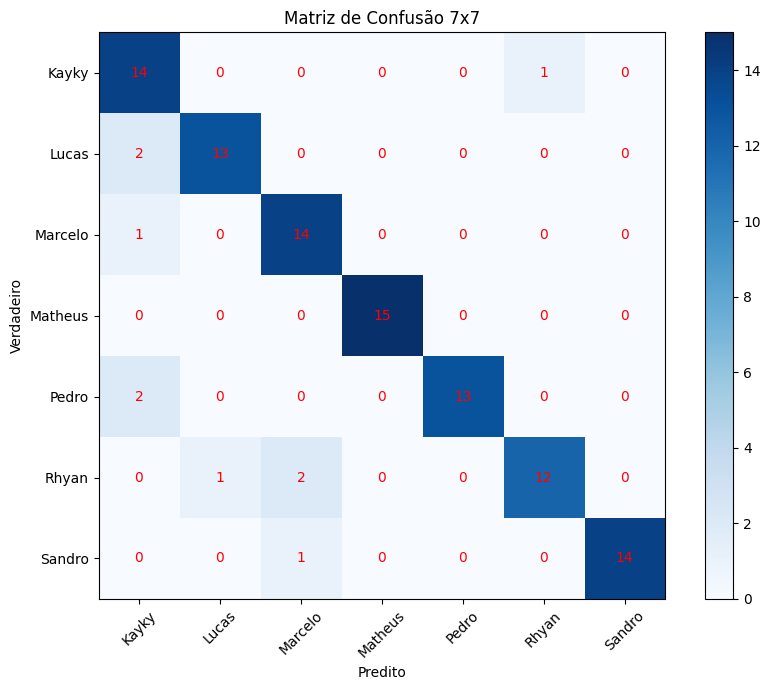

              precision    recall  f1-score   support

       Kayky       0.74      0.93      0.82        15
       Lucas       0.93      0.87      0.90        15
     Marcelo       0.82      0.93      0.88        15
     Matheus       1.00      1.00      1.00        15
       Pedro       1.00      0.87      0.93        15
       Rhyan       0.92      0.80      0.86        15
      Sandro       1.00      0.93      0.97        15

    accuracy                           0.90       105
   macro avg       0.92      0.90      0.91       105
weighted avg       0.92      0.90      0.91       105



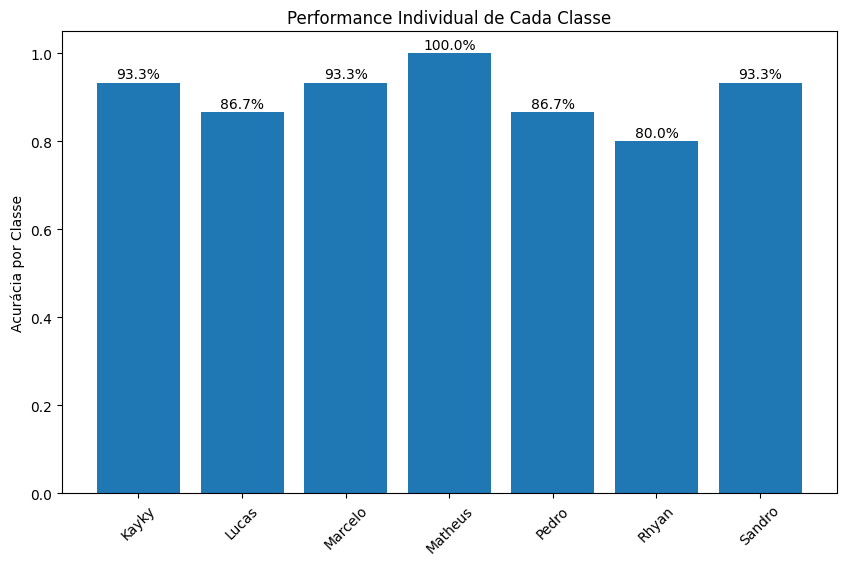

In [ ]:
# 8. Avaliação: matriz de confusão (base + desconhecido se houver)
labels_eval = list(classes) + (["César"] if pred_final else [])
y_true_all = np.concatenate([y_test, np.array(y_new)]) if pred_final else y_test
y_pred_all = np.concatenate([y_test_pred, np.array(pred_final)]) if pred_final else y_test_pred
cm = confusion_matrix(y_true_all, y_pred_all, labels=labels_eval)
accuracy = accuracy_score(y_true_all, y_pred_all)
print(f"\n{'='*50}")
print(f"Acurácia total no teste: {accuracy*100:.2f}%")
print(f"{'='*50}")

def plot_confusion_matrix(cm, labels_eval):
    plt.figure(figsize=(9,7))
    plt.imshow(cm, cmap='Blues')
    plt.title(f"Matriz de Confusão {len(labels_eval)}x{len(labels_eval)}")
    plt.xlabel("Predito")
    plt.ylabel("Verdadeiro")
    plt.xticks(np.arange(len(labels_eval)), labels_eval, rotation=45)
    plt.yticks(np.arange(len(labels_eval)), labels_eval)
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='red')
    plt.colorbar()
    plt.tight_layout()
    plt.show()
plot_confusion_matrix(cm, labels_eval)
print(classification_report(y_true_all, y_pred_all, target_names=labels_eval))

# Gráfico por classe corrigido
import numpy as np
yt_np, yp_np = np.array(y_true_all), np.array(y_pred_all)
class_acc = []
for cls in labels_eval:
    mask = (yt_np == cls)
    acc_cls = np.mean(yp_np[mask] == cls) if mask.sum() else 0.
    class_acc.append(acc_cls)
plt.figure(figsize=(10,6))
plt.bar(labels_eval, class_acc)
plt.ylabel('Acurácia por Classe')
plt.title('Performance Individual de Cada Classe')
plt.xticks(rotation=45)
for i, v in enumerate(class_acc):
    plt.text(i, v + 0.01, f'{v*100:.1f}%', ha='center')
plt.ylim(0, 1.05)
plt.show()


In [ ]:
import plotly.graph_objects as go
import numpy as np
from sklearn.decomposition import PCA

# Projeção PCA 3D dos embeddings
pca3 = PCA(n_components=3, random_state=42)
feats_tr_pca3 = pca3.fit_transform(feats_tr)

# Garante array de rótulos
classes_list = list(class_to_color)  # nomes das pessoas

fig = go.Figure()

for nome, cor in class_to_color.items():
    mask = (ytr_arr == nome)
    fig.add_trace(go.Scatter3d(
        x=feats_tr_pca3[mask, 0],
        y=feats_tr_pca3[mask, 1],
        z=feats_tr_pca3[mask, 2],
        mode='markers',
        marker=dict(size=5, color=cor, opacity=0.78),
        name=nome,            # Nome que aparece na legenda
        showlegend=True      # Garante legenda para este grupo
    ))

fig.update_layout(
    title='Embeddings (PCA 3D) - legenda por pessoa',
    scene=dict(xaxis_title='PC1', yaxis_title='PC2', zaxis_title='PC3'),
    legend=dict(title='Pessoa', x=1, y=0.5, xanchor='left'),
    height=700,
    width=950
)
fig.show()


In [ ]:
import numpy as np

# Escolha uma imagem amostra para testar (por exemplo, a primeira do conjunto de teste)
indice_amostra = 0
imagem_amostra = X_test[indice_amostra:indice_amostra+1]  # deve ser um batch com shape (1, H, W, C)

# Gere o embedding usando o modelo de extração
embedding_vetor = embedding_model.predict(imagem_amostra)

# embedding_vetor terá shape (1, 128); extraímos o vetor 1D com [0]
embedding_vetor = embedding_vetor[0]

# Imprime o vetor de 128 valores
print("Embedding da imagem amostra (128 dimensões):")
print(embedding_vetor)

# (Opcional) Para imprimir de forma mais legível, formate os valores
for i, val in enumerate(embedding_vetor):
    print(f"Dim {i+1}: {val:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step
Embedding da imagem amostra (128 dimensões):
[ 0.          0.          6.0898447   0.          0.          0.
  7.0115633   0.          0.          0.          1.2702968  14.367918
  6.728686    0.          0.          5.5439606   0.          0.2583467
  2.3797805   0.          0.          0.          0.          0.
  0.          0.         10.182947    0.          9.751498    0.
 15.93706     0.          0.          0.          0.          0.
  2.6472564   0.          0.          0.          0.          0.
  0.          0.          2.245384    0.          0.          0.
  0.          6.2172813   6.1261563   0.          0.          1.5700631
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          3.0373356   0.          0.
  0.          5.46628     3.228099    0.          0.          0.
 10.261623    0.         10.667096    0.          0.  

In [ ]:
# @title
# === CÉLULA: SALVAR MODELO KERAS NO GOOGLE DRIVE ===
# Salva:
#  - model.keras (modelo principal)
#  - embedding_model.keras (se existir)
#  - classes.json (lista de classes/pessoas)
#  em /content/drive/MyDrive/CNN_Classificacao_Rostos/modelos/<timestamp>/

import os, time, json, pathlib

# 1) Montar o Google Drive (Colab)
try:
    from google.colab import drive  # já importado no notebook, mas seguro repetir
    drive.mount('/content/drive', force_remount=False)
    print("Drive montado em /content/drive")
except Exception as e:
    print("Aviso: monte o Drive manualmente se estiver fora do Colab:", e)

# 2) Pasta de saída com versionamento (timestamp)
STAMP = time.strftime("%Y%m%d-%H%M%S")
BASE_DIR = "/content/drive/MyDrive/CNN_Classificacao_Rostos/modelos"
OUT_DIR = os.path.join(BASE_DIR, f"modelo_{STAMP}")
os.makedirs(OUT_DIR, exist_ok=True)

# 3) Salvar modelos Keras
try:
    import tensorflow as tf
except Exception as e:
    raise RuntimeError("TensorFlow/Keras não disponível no ambiente.") from e

saved = []

# Salvar o modelo principal (variável 'model' usada no notebook)
if 'model' in globals() and isinstance(globals()['model'], tf.keras.Model):
    model_path = os.path.join(OUT_DIR, "model.keras")
    globals()['model'].save(model_path)
    saved.append(model_path)
    print(f"[OK] Modelo salvo: {model_path}")
else:
    print("Aviso: variável 'model' não encontrada como tf.keras.Model.")

# Salvar o modelo de embeddings, se existir
if 'embedding_model' in globals() and isinstance(globals()['embedding_model'], tf.keras.Model):
    emb_path = os.path.join(OUT_DIR, "embedding_model.keras")
    globals()['embedding_model'].save(emb_path)
    saved.append(emb_path)
    print(f"[OK] Embeddings salvos: {emb_path}")
else:
    print("Obs: 'embedding_model' não encontrado; pulando.")

# 4) Salvar metadados: classes (lista de pessoas)
meta = {}
if 'classes' in globals():
    try:
        meta['classes'] = list(globals()['classes'])
    except Exception:
        pass

# 5) Persistir metadados
try:
    with open(os.path.join(OUT_DIR, "classes.json"), "w", encoding="utf-8") as f:
        json.dump(meta.get('classes', []), f, ensure_ascii=False, indent=2)
        print(f"[OK] classes.json salvo em {OUT_DIR}/classes.json")
except Exception as e:
    print("Aviso: falha ao salvar classes.json:", e)

# (Opcional) salvar histórico, se você tiver guardado o retorno do model.fit como 'history'
if 'history' in globals():
    try:
        with open(os.path.join(OUT_DIR, "history.json"), "w", encoding="utf-8") as f:
            json.dump(getattr(globals()['history'], 'history', {}), f, ensure_ascii=False, indent=2)
            print(f"[OK] history.json salvo em {OUT_DIR}/history.json")
    except Exception as e:
        print("Obs: não foi possível salvar history.json:", e)

# 6) Listar conteúdo salvo
print("\nArquivos salvos em:", OUT_DIR)
for p in sorted(pathlib.Path(OUT_DIR).glob("*")):
    print(" -", p.name)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Drive montado em /content/drive
[OK] Modelo salvo: /content/drive/MyDrive/CNN_Classificacao_Rostos/modelos/modelo_20251109-204006/model.keras
[OK] Embeddings salvos: /content/drive/MyDrive/CNN_Classificacao_Rostos/modelos/modelo_20251109-204006/embedding_model.keras
[OK] classes.json salvo em /content/drive/MyDrive/CNN_Classificacao_Rostos/modelos/modelo_20251109-204006/classes.json

Arquivos salvos em: /content/drive/MyDrive/CNN_Classificacao_Rostos/modelos/modelo_20251109-204006
 - classes.json
 - embedding_model.keras
 - model.keras
